# 1 去掉取值变化小的特征 (Removing features with low variance)

In [1]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

# 2 单变量特征选择 (Univariate feature selection)
## 2.1 Pearson相关系数

In [2]:
import numpy as np
from scipy.stats import pearsonr
np.random.seed(0)
size = 300
x = np.random.normal(0, 1, size)
print( "Lower noise", pearsonr(x, x + np.random.normal(0, 1, size)))
print( "Higher noise", pearsonr(x, x + np.random.normal(0, 10, size)))

Lower noise (0.71824836862138408, 7.3240173129983507e-49)
Higher noise (0.057964292079338155, 0.31700993885324752)


In [3]:
x1 = np.random.uniform(-1, 1, 100000)  
print( pearsonr(x1, x1**2)[0]) 

-0.00230804707612


## 2.2 互信息和最大信息系数

In [4]:
from minepy import MINE  
m = MINE()  
x = np.random.uniform(-1, 1, 10000)  
m.compute_score(x, x**2)  
print( m.mic()) 

1.0000000000000009


##  2.4 基于学习模型的特征排序 (Model based ranking)

In [5]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit  
from sklearn.datasets import load_boston  
from sklearn.ensemble import RandomForestRegressor  
  
#Load boston housing dataset as an example  
boston = load_boston()  
X = boston["data"]  
Y = boston["target"]  
names = boston["feature_names"]  
  
rf = RandomForestRegressor(n_estimators=20, max_depth=4)  
scores = []  
for i in range(X.shape[1]):  
    score = cross_val_score(rf, X[:, i:i+1], Y, scoring="r2",cv=ShuffleSplit(len(X), 3, .3))  
    scores.append((round(np.mean(score), 3), names[i]))  
#print (sorted(scores, reverse=True) ) 
sorted(scores, reverse=True)

D:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[(0.60999999999999999, 'LSTAT'),
 (0.44800000000000001, 'RM'),
 (0.35599999999999998, 'NOX'),
 (0.309, 'INDUS'),
 (0.28899999999999998, 'PTRATIO'),
 (0.23999999999999999, 'TAX'),
 (0.23100000000000001, 'ZN'),
 (0.19900000000000001, 'CRIM'),
 (0.19, 'RAD'),
 (0.11600000000000001, 'B'),
 (0.091999999999999998, 'AGE'),
 (0.048000000000000001, 'DIS'),
 (0.010999999999999999, 'CHAS')]

# 3 线性模型和正则化

## 3.1 线性模型

In [6]:
from sklearn.linear_model import LinearRegression  
import numpy as np  
  
np.random.seed(0)  
size = 5000  
  
#A dataset with 3 features  
X = np.random.normal(0, 1, (size, 3))  
#Y = X0 + 2*X1 + noise  
Y = X[:,0] + 2*X[:,1] + np.random.normal(0, 2, size)  
lr = LinearRegression()  
lr.fit(X, Y)  
  
#A helper method for pretty-printing linear models  
def pretty_print_linear(coefs, names = None, sort = False):  
    if names == None:  
        names = ["X%s" % x for x in range(len(coefs))]  
    lst = zip(coefs, names)  
    if sort:  
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))  
    return " + ".join("%s * %s" % (round(coef, 3), name)  
                                   for coef, name in lst)  
  
print ("Linear model:", pretty_print_linear(lr.coef_))  

Linear model: 0.984 * X0 + 1.995 * X1 + -0.041 * X2


In [7]:
size = 100  
np.random.seed(seed=5)  
  
X_seed = np.random.normal(0, 1, size)  
X1 = X_seed + np.random.normal(0, .1, size)  
X2 = X_seed + np.random.normal(0, .1, size)  
X3 = X_seed + np.random.normal(0, .1, size)  
  
Y = X1 + X2 + X3 + np.random.normal(0,1, size)  
X = np.array([X1, X2, X3]).T  
  
lr = LinearRegression()  
lr.fit(X,Y)  
print ("Linear model:", pretty_print_linear(lr.coef_))

Linear model: -1.291 * X0 + 1.591 * X1 + 2.747 * X2


## 3.2 正则化
### 3.2.1 L1正则化/Lasso

In [8]:
from sklearn.linear_model import Lasso  
from sklearn.preprocessing import StandardScaler  
from sklearn.datasets import load_boston  
  
boston = load_boston()  
scaler = StandardScaler()  
X = scaler.fit_transform(boston["data"])  
Y = boston["target"]  
names = boston["feature_names"]  
  
lasso = Lasso(alpha=.3)  
lasso.fit(X, Y)  
  
print("Lasso model: ", pretty_print_linear(lasso.coef_, list(names), sort = True))  


Lasso model:  -3.707 * LSTAT + 2.992 * RM + -1.757 * PTRATIO + -1.081 * DIS + -0.7 * NOX + 0.631 * B + 0.54 * CHAS + -0.236 * CRIM + 0.081 * ZN + -0.0 * INDUS + -0.0 * AGE + 0.0 * RAD + -0.0 * TAX


### 3.2.2 L2正则化/Ridge regression

In [9]:
from sklearn.linear_model import Ridge  
from sklearn.metrics import r2_score  
size = 100  
  
#We run the method 10 times with different random seeds  
for i in range(10):  
    print("Random seed %s" % i)  
    np.random.seed(seed=i)  
    X_seed = np.random.normal(0, 1, size)  
    X1 = X_seed + np.random.normal(0, .1, size)  
    X2 = X_seed + np.random.normal(0, .1, size)  
    X3 = X_seed + np.random.normal(0, .1, size)  
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)  
    X = np.array([X1, X2, X3]).T  
  
  
    lr = LinearRegression()  
    lr.fit(X,Y)  
    print ("Linear model:", pretty_print_linear(lr.coef_))
  
    ridge = Ridge(alpha=10)  
    ridge.fit(X,Y)  
    print("Ridge model:", pretty_print_linear(ridge.coef_)) 

Random seed 0
Linear model: 0.728 * X0 + 2.309 * X1 + -0.082 * X2
Ridge model: 0.938 * X0 + 1.059 * X1 + 0.877 * X2
Random seed 1
Linear model: 1.152 * X0 + 2.366 * X1 + -0.599 * X2
Ridge model: 0.984 * X0 + 1.068 * X1 + 0.759 * X2
Random seed 2
Linear model: 0.697 * X0 + 0.322 * X1 + 2.086 * X2
Ridge model: 0.972 * X0 + 0.943 * X1 + 1.085 * X2
Random seed 3
Linear model: 0.287 * X0 + 1.254 * X1 + 1.491 * X2
Ridge model: 0.919 * X0 + 1.005 * X1 + 1.033 * X2
Random seed 4
Linear model: 0.187 * X0 + 0.772 * X1 + 2.189 * X2
Ridge model: 0.964 * X0 + 0.982 * X1 + 1.098 * X2
Random seed 5
Linear model: -1.291 * X0 + 1.591 * X1 + 2.747 * X2
Ridge model: 0.758 * X0 + 1.011 * X1 + 1.139 * X2
Random seed 6
Linear model: 1.199 * X0 + -0.031 * X1 + 1.915 * X2
Ridge model: 1.016 * X0 + 0.89 * X1 + 1.091 * X2
Random seed 7
Linear model: 1.474 * X0 + 1.762 * X1 + -0.151 * X2
Ridge model: 1.018 * X0 + 1.039 * X1 + 0.901 * X2
Random seed 8
Linear model: 0.084 * X0 + 1.88 * X1 + 1.107 * X2
Ridge model:

### 3.2.3 弹性网络/Elastic Net 

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.385982
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.240498


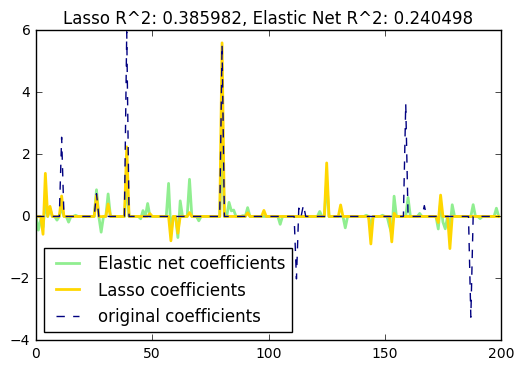

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

# #############################################################################
# Generate some sparse data to play with
np.random.seed(42)

n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal(size=n_samples)

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:n_samples // 2], y[:n_samples // 2]
X_test, y_test = X[n_samples // 2:], y[n_samples // 2:]

# #############################################################################
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

# #############################################################################
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

# 4 随机森林
## 4.1平均不纯度减少 mean decrease impurity

In [11]:
from sklearn.datasets import load_boston  
from sklearn.ensemble import RandomForestRegressor  
import numpy as np  
#Load boston housing dataset as an example  
boston = load_boston()  
X = boston["data"]  
Y = boston["target"]  
names = boston["feature_names"]  
rf = RandomForestRegressor()  
rf.fit(X, Y)  
print ("Features sorted by their score:")  
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names),reverse=True))  

Features sorted by their score:
[(0.41760000000000003, 'RM'), (0.38159999999999999, 'LSTAT'), (0.058500000000000003, 'DIS'), (0.043900000000000002, 'CRIM'), (0.028899999999999999, 'NOX'), (0.0155, 'TAX'), (0.0137, 'B'), (0.0137, 'AGE'), (0.013299999999999999, 'PTRATIO'), (0.0074000000000000003, 'INDUS'), (0.0038, 'RAD'), (0.0011000000000000001, 'ZN'), (0.001, 'CHAS')]


In [12]:
size = 10000  
np.random.seed(seed=10)  
X_seed = np.random.normal(0, 1, size)  
X0 = X_seed + np.random.normal(0, .1, size)  
X1 = X_seed + np.random.normal(0, .1, size)  
X2 = X_seed + np.random.normal(0, .1, size)  
X = np.array([X0, X1, X2]).T  
Y = X0 + X1 + X2  
  
rf = RandomForestRegressor(n_estimators=20, max_features=2)  
rf.fit(X, Y)
print ("Scores for X0, X1, X2:", list(map(lambda x:round (x,3), rf.feature_importances_)) )  


Scores for X0, X1, X2: [0.27200000000000002, 0.54800000000000004, 0.17899999999999999]


## 4.2 平均精确率减少(Mean decrease accuracy)

In [13]:
from sklearn.cross_validation import ShuffleSplit  
from sklearn.metrics import r2_score  
from collections import defaultdict  
  
X = boston["data"]  
Y = boston["target"]  
  
rf = RandomForestRegressor()  
scores = defaultdict(list)  
  
#crossvalidate the scores on a number of different random splits of the data  
for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):  
    X_train, X_test = X[train_idx], X[test_idx]  
    Y_train, Y_test = Y[train_idx], Y[test_idx]  
    r = rf.fit(X_train, Y_train)  
    acc = r2_score(Y_test, rf.predict(X_test))  
    for i in range(X.shape[1]):  
        X_t = X_test.copy()  
        np.random.shuffle(X_t[:, i])  
        shuff_acc = r2_score(Y_test, rf.predict(X_t))  
        scores[names[i]].append((acc-shuff_acc)/acc)  
print ("Features sorted by their score:")  
print (sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True))  

Features sorted by their score:
[(0.73109999999999997, 'LSTAT'), (0.57089999999999996, 'RM'), (0.087999999999999995, 'DIS'), (0.0385, 'NOX'), (0.036600000000000001, 'CRIM'), (0.023400000000000001, 'PTRATIO'), (0.017100000000000001, 'TAX'), (0.0129, 'AGE'), (0.0047000000000000002, 'B'), (0.0044999999999999997, 'INDUS'), (0.0035000000000000001, 'RAD'), (0.0001, 'ZN'), (-0.0001, 'CHAS')]


# 5 两种顶层特征选择算法
## 5.1 稳定性选择(Stability selection)

In [14]:
from sklearn.linear_model import RandomizedLasso  
from sklearn.datasets import load_boston  
boston = load_boston()  
  
#using the Boston housing data.   
#Data gets scaled automatically by sklearn's implementation  
X = boston["data"]  
Y = boston["target"]  
names = boston["feature_names"]  
  
rlasso = RandomizedLasso(alpha=0.025)  
rlasso.fit(X, Y)  
  
print ("Features sorted by their score:")  
print (sorted(zip(map(lambda x: round(x, 4), rlasso.scores_),names), reverse=True))  

D:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


Features sorted by their score:
[(1.0, 'RM'), (1.0, 'PTRATIO'), (1.0, 'LSTAT'), (0.64500000000000002, 'CHAS'), (0.57499999999999996, 'B'), (0.40000000000000002, 'TAX'), (0.39500000000000002, 'CRIM'), (0.245, 'NOX'), (0.185, 'DIS'), (0.16500000000000001, 'INDUS'), (0.055, 'ZN'), (0.029999999999999999, 'RAD'), (0.01, 'AGE')]


## 5.2 递归特征消除 (Recursive feature elimination (RFE) )

In [15]:
from sklearn.feature_selection import RFE  
from sklearn.linear_model import LinearRegression  
  
boston = load_boston()  
X = boston["data"]  
Y = boston["target"]  
names = boston["feature_names"]  
  
#use linear regression as the model  
lr = LinearRegression()  
#rank all features, i.e continue the elimination until the last one  
rfe = RFE(lr, n_features_to_select=1)  
rfe.fit(X,Y)  
  
print ("Features sorted by their rank:")  
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))  

Features sorted by their rank:
[(1, 'NOX'), (2, 'RM'), (3, 'CHAS'), (4, 'PTRATIO'), (5, 'DIS'), (6, 'LSTAT'), (7, 'RAD'), (8, 'CRIM'), (9, 'INDUS'), (10, 'ZN'), (11, 'TAX'), (12, 'B'), (13, 'AGE')]


# 一个完整的例子

In [16]:
from sklearn.datasets import load_boston  
from sklearn.linear_model import (LinearRegression, Ridge,Lasso, RandomizedLasso)  
from sklearn.feature_selection import RFE, f_regression  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.ensemble import RandomForestRegressor  
import numpy as np  
from minepy import MINE  
  
np.random.seed(0)  
  
size = 750  
X = np.random.uniform(0, 1, (size, 14))  
  
#"Friedamn #1” regression problem  
Y = (10 * np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2] - .5)**2 +  
     10*X[:,3] + 5*X[:,4] + np.random.normal(0,1))  
#Add 3 additional correlated variables (correlated with X1-X3)  
X[:,10:] = X[:,:4] + np.random.normal(0, .025, (size,4))  
  
names = ["x%s" % i for i in range(1,15)]  
  
ranks = {}  
  
def rank_to_dict(ranks, names, order=1):  
    minmax = MinMaxScaler()  
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]  
    ranks = map(lambda x: round(x, 2), ranks)  
    return dict(zip(names, ranks ))  
  
lr = LinearRegression(normalize=True)  
lr.fit(X, Y)  
ranks["Lr reg"] = rank_to_dict(np.abs(lr.coef_), names)  
  
ridge = Ridge(alpha=7)  
ridge.fit(X, Y)  
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)  
   
lasso = Lasso(alpha=.05)  
lasso.fit(X, Y)  
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)  
    
rlasso = RandomizedLasso(alpha=0.04)  
rlasso.fit(X, Y)  
ranks["Stab"] = rank_to_dict(np.abs(rlasso.scores_), names)  
  
#stop the search when 5 features are left (they will get equal scores)  
rfe = RFE(lr, n_features_to_select=5)  
rfe.fit(X,Y)  
ranks["RFE"] = rank_to_dict(list(map(float, rfe.ranking_)), names, order=-1)  
  
rf = RandomForestRegressor()  
rf.fit(X,Y)  
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)    
  
f, pval  = f_regression(X, Y, center=True)  
ranks["Corr."] = rank_to_dict(f, names)  
  
mine = MINE()  
mic_scores = []  
for i in range(X.shape[1]):  
    mine.compute_score(X[:,i], Y)  
    m = mine.mic()  
    mic_scores.append(m)    
ranks["MIC"] = rank_to_dict(mic_scores, names)    
  
r = {}  
for name in names:  
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)    
methods = sorted(ranks.keys())  
ranks["Mean"] = r  
methods.append("Mean")  
  
# ranks = pd.DataFrame(ranks)
print("\t%s" % "\t".join(methods))  
for name in names:  
    print("%s\t%s" % (name, "\t".join(map(str,[ranks[method][name] for method in methods]))))

D:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


	Corr.	Lasso	Lr reg	MIC	RF	RFE	Ridge	Stab	Mean
x1	0.3	0.79	1.0	0.39	0.55	1.0	0.77	0.77	0.7
x2	0.44	0.83	0.56	0.61	0.67	1.0	0.75	0.72	0.7
x3	0.0	0.0	0.5	0.34	0.13	1.0	0.05	0.0	0.25
x4	1.0	1.0	0.57	1.0	0.56	1.0	1.0	1.0	0.89
x5	0.1	0.51	0.27	0.2	0.29	0.78	0.88	0.55	0.45
x6	0.0	0.0	0.02	0.0	0.01	0.44	0.05	0.0	0.06
x7	0.01	0.0	0.0	0.07	0.02	0.0	0.01	0.0	0.01
x8	0.02	0.0	0.03	0.05	0.01	0.56	0.09	0.0	0.1
x9	0.01	0.0	0.0	0.09	0.01	0.11	0.0	0.0	0.03
x10	0.0	0.0	0.01	0.04	0.0	0.33	0.01	0.0	0.05
x11	0.29	0.0	0.6	0.43	0.39	1.0	0.59	0.37	0.46
x12	0.44	0.0	0.14	0.71	0.35	0.67	0.68	0.46	0.43
x13	0.0	0.0	0.48	0.23	0.07	0.89	0.02	0.0	0.21
x14	0.99	0.16	0.0	1.0	1.0	0.22	0.95	0.62	0.62
